# 7-Laboratory-18-11-2020
 

> Credits to the authors of the exercises: Andrea Pasini, Giuseppe Attanasio, Flavio Giobergia <br />
Master of Science in Data Science and Engineering, Politecnico di Torino, A.A. 2020-21

## Free Spoken Digit Dataset
The dataset for this laboratory has been inspired by the Free Spoken Digit Dataset. It is composed of 2,000 recordings by 4 speakers of numbers from 0 to 9 with English pronunciation. Thus, each digit has a total of 50 recordings per speaker. Each recording is a mono wav file. The sampling rate is 8 kHz. 

The recordings are trimmed so that they have near minimal silence at the beginnings andends. The data has been distributed uniformly in two separate collections:
- Development (dev): a collection composed of 1500 recordingswiththe ground-truth labels. Thiscollection of data has to be used during the development of the classification model. Each file in thisportion of the dataset is a recording named with the following format<Id>_<Label>.wav
- Evaluation (eval): a collection composed of 500 recordings without the labels. This collection of data has to be used to produce the submission file containing the labels predicted for each evaluationrecording, exploiting the previously built model. Each file in this portion of the dataset is a recordingnamed with the following format<Id>.wav

So far, you should be used to work, developing your models, with training, validation and test sets. Inthis case, the Development data must be used to tune your hyper-parameters while you should considerthe Evaluation portion as the actual test set.
    
In this exercise you will build a complete data analytics pipeline to pre-process your audio signals and builda classification model able to distinguish between the classes available in the dataset. More specifically, you will load, analyze and prepare the Free Spoken Digit dataset to train and validate a classification model. Finally, you will be able to upload your classification results and participate to the lab competition.
    
## Data mining
Load the dataset from the root folder. Here the Python’s os module comes to your help. You can usethe os.listdir function to list files in a directory. Furthermore, you can use the wave file module from SciPy to read a file in wav format. You can read more about it on the official documentation

In [1]:
import os 
import numpy as np
from scipy.io import wavfile

def get_data(type):
    
    if type not in ['eval','dev']:
        print("-- Parametro non riconosciuto")
        exit(0)
    
    path = '../Datasets/free-spoken-digit/' + type + '/'
    
    audio_files = os.listdir(path)
    
    # we have to initialize them
    # otherwise we cannot have access trough indices
    X = [None for i in range(len(audio_files))]
    y = [None for i in range(len(audio_files))]
    rates = [None for i in range(len(audio_files))]
    
    id_audio = None
    
    for audio_file in audio_files:
        
        """
            eval and dev have two different structures
                dev  : id_label.wav
                eval : id.wav 
        """ 
        
        # id
        if type == "dev":
            id_audio = int(audio_file.split("_")[0])
            y[id_audio] = int(audio_file.split(".")[0].split("_")[1])
        else:
            id_audio = int(audio_file.split(".")[0])
        
        complete_path = path + audio_file
        
        rates[id_audio], X[id_audio] = wavfile.read(complete_path)

    return rates, X, y 

In [2]:
Rates_eval, X_eval, _  = get_data('eval')
Rates_dev,  X_dev, y_dev = get_data('dev')

In [3]:
Rates_eval[:2], X_eval[:2]

([8000, 8000],
 [array([   0,    0, -512, ...,    0, -256, -256], dtype=int16),
  array([  6,   0,  -3, ..., -11,  -2, -20], dtype=int16)])

In [4]:
Rates_dev[:2], X_dev[:2], y_dev[:2]

([8000, 8000],
 [array([ 14,  21,   0, ...,   3, -48, -80], dtype=int16),
  array([-2, 12,  1, ...,  3, -3,  3], dtype=int16)],
 [4, 7])

## Data exploration
The wavfile.read() method returns an integer value and  one array. The first one is the rate of the audio track, and the second one is an array containing samples of the audio signal, so the amplitude spaced evenly in time. 

In [5]:
print("Rates eval :\t", set(Rates_eval))
print("Rates dev  :\t", set(Rates_dev))

Rates eval :	 {8000}
Rates dev  :	 {8000}


So, another important feature is that we're dealing with the same Sample Rates for both evaluation and developement  audio tracks. Now we can also evaluate the mean and the standard deviation about the audios' volume, defined with the well-know formula as follows: 

In [7]:
import math
dbs_dev = [ 20*np.log10(np.sqrt(np.mean(audio**2))) for audio in X_dev if np.mean(audio**2) > 0]
dbs_eval = [ 20*np.log10(np.sqrt(np.mean(audio**2))) for audio in X_eval if np.mean(audio**2) > 0]

print(np.array(dbs_dev).mean(), np.array(dbs_dev).std(), sep="\t")
print(np.array(dbs_eval).mean(), np.array(dbs_eval).std(), sep="\t")

32.35172786014707	2.862332050097958
32.39866107795697	2.9219932739238357


Actually it is not that bad, there is a small standard deviation, so it means that most of the values are close to the mean. The very last thing that I'd like to see is the length distribution of those arrays. 

Text(0.5, 1.0, 'length_eval')

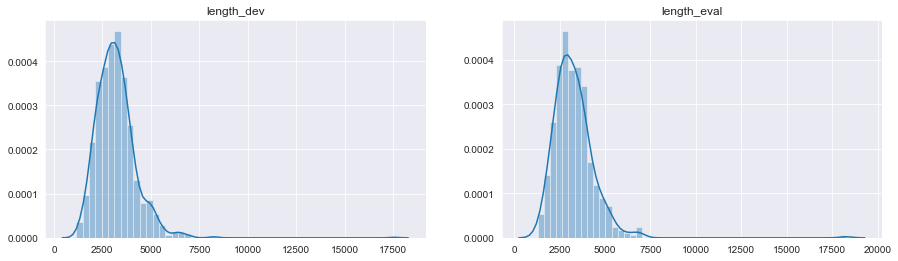

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

lengths_dev = [ len(audio) for audio in X_dev]
lengths_eval = [ len(audio) for audio in X_eval]

fig, ax = plt.subplots(1,2,figsize=(15,4))

sns.distplot(lengths_dev, ax=ax[0])
ax[0].set_title('length_dev')
sns.distplot(lengths_eval, ax=ax[1])
ax[1].set_title('length_eval')

Their distribution is quite similar, but both groups of audio have a wide range of lengths. We could expect that, because some numbers are "longer" than others. It could be a problem, but in order to fix that we can think to operate in chunks (portion of the audio track) and make some statistical estimation on those portions. Now we can start diving into the time domain, and see the variance of the amplitude.

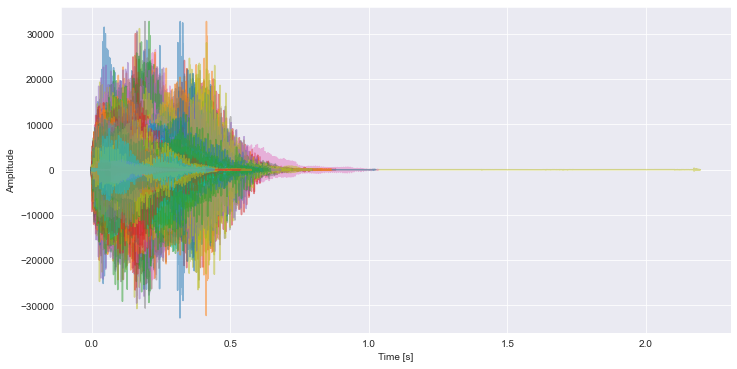

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_amplitude(X):
    sns.set_style("darkgrid")
    plt.figure(figsize=(12,6))

    for i,x in enumerate(X):

        length = x.shape[0] / Rates_dev[i]
        time = np.linspace(0., length, x.shape[0])
        plt.plot(time, x, alpha=0.5)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        
    return plt

plot_amplitude(X_dev).show()

Besides the length of those arrays, we have also a huge variance of amplitude. So as I mentioned before, the best thing to do is to divide those recordings in chunk and just then, we can make some statistical considerations.

## Preprocessing
Actually, since there is a huge variance among all those signals, it could be useful to normalize them. The aim of normalization is to adjust values measured (or in this case, recorder) on different scales. The two common ways for normalizing data are the "min-max" and "z-score" methods. The first one distributes its values into a range of [0,1], and I don't think this is the perfect scenario to do that. On the other hand, the z-score normalization instead, is defined as:
<br /><br />
<center>$z-score = \frac {X-\mu} {\sigma}$</center>
<br /><br />
So, the z-score subtracts for each value the mean, and then divide it from the standard deviation. We could do tha with scipy.stats.zscore that needs the array that we want to normalize, and returns the normalized array. 

In [84]:
from scipy.stats import zscore
def normalize(X):
    return [zscore(arr) for arr in X]

X_dev_norm = normalize(X_dev)
X_eval_norm = normalize(X_eval)

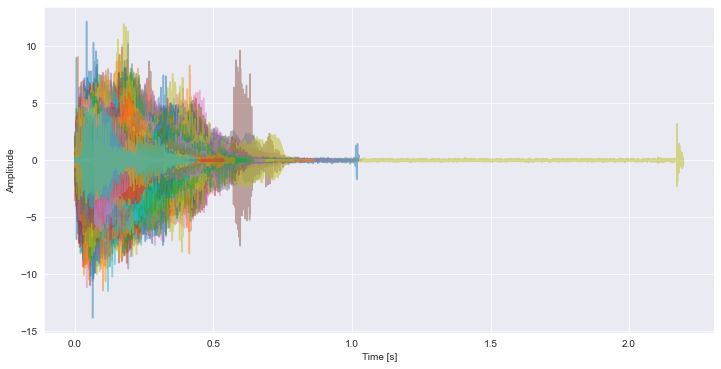

In [85]:
plot_amplitude(X_dev_norm).show()

Now it is much more regular than before. Once we normalize the audio tracks we should start to make some "statistical" measure on some audio chunks, as the instructors suggested. <br />

In order to split our set into several chunks, we have to consider our Sample Rate, that is 8000 for each one. The sample rate tell us that we need 8000 elements of our array in order to have 1 second. It is quite important to choose a proper length for each chunk, because a little chuck may not add any particular information, and a larger one may generalize too much that signal. Since most of the amplitudes are concentrated in the first 0.8 seconds, we could try to split each second into 10 chunks. 